In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
#from spikingjelly.activation_based import neuron, functional, surrogate, layer
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

In [2]:
from datasets import load_dataset
# import torchaudio

# data = load_dataset('google/speech_commands', 'v0.01', split=['train','test'], trust_remote_code=True)
train_set = load_dataset('google/speech_commands', 'v0.01', split='train', trust_remote_code=True)
test_set = load_dataset('google/speech_commands', 'v0.01', split='test', trust_remote_code=True)


In [3]:
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import LabelEncoder

# inspect the dataset
print("tain_set:\n", train_set)
print("shape of train_set: ", train_set.shape)

# train_set = data['train']
# train_set = torchaudio.datasets.SPEECHCOMMANDS(root='C:/Users/wasse/hello', download=True, subset='training')
# test_set = torchaudio.datasets.SPEECHCOMMANDS(root='C:/Users/wasse/hello', download=True, subset='testing')

max_length = 16000  # or your desired length
# Assume `labels` contains the string labels from your dataset
# all_labels = [item[2] for item in train_set] 
all_labels = train_set['label']
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(all_labels)


def collate_fn(batch):
    max_length = 16000
    # waveforms, labels = zip(*[(item[0].squeeze()[:max_length], item[2]) for item in batch])
    waveforms, labels = zip(*[(torch.tensor(item['audio']['array'][:max_length]) , item['label'])
                              for item in batch])
    # Ensure each waveform is 1D before padding
    waveforms = [waveform if waveform.ndim == 1 else waveform.mean(dim=0) for waveform in waveforms]

    #print("Shapes before padding:", [w.shape for w in waveforms])  # Add this line

    waveforms_padded = pad_sequence(waveforms, batch_first=True, padding_value=0)

    labels = label_encoder.transform(labels)  # Encode the labels as integers

    labels = torch.tensor(labels)
    #print('done')
    return waveforms_padded, labels


train_loader = DataLoader(train_set, batch_size=64, shuffle=True, collate_fn=collate_fn, drop_last=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, collate_fn=collate_fn, drop_last=True)

tain_set:
 Dataset({
    features: ['file', 'audio', 'label', 'is_unknown', 'speaker_id', 'utterance_id'],
    num_rows: 51093
})
shape of train_set:  (51093, 6)


torch.Size([64, 16000]) torch.Size([64])
tensor(6)


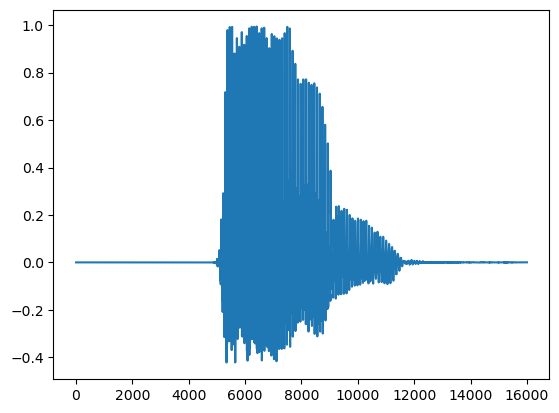

In [4]:
# show samples
sample_batch = next(iter(train_loader))
# reinstialize the train_loader to get the first batch
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, collate_fn=collate_fn, drop_last=True)

# inspect one sample and its label
print(sample_batch[0].shape, sample_batch[1].shape)
print(sample_batch[1][0])
plt.plot(sample_batch[0][0].numpy())

# # play the audio
# import IPython.display as ipd
# import scipy.io.wavfile
# ipd.Audio(sample[0][0].numpy(), rate=16000)
# scipy.io.wavfile.write('sample.wav', 16000, sample[0][0].numpy())

In [5]:
from scipy.signal.windows import exponential, gaussian
from scipy.signal import square, ShortTimeFFT

sample_rate=16000
g_std = 10      # standard deviation for Gaussian window in samples
win_size = 40   # window size in samples
win_gauss = gaussian(win_size, std=g_std, sym=True)  # symmetric Gaussian wind.
SFT = ShortTimeFFT(win_gauss, hop=2, fs=sample_rate, mfft=2000, scale_to='psd')
batch_size = 64
num_samples = 16000

duration = num_samples / sample_rate

In [6]:
import numpy as np
from scipy.signal import stft
import librosa

"""
def mel_spectrogram(audio, sample_rate, n_mels=128, f_min=0, f_max=None):
  if f_max is None:
    f_max = sample_rate / 2
  _, _, spectrogram = stft(audio, nperseg=512, noverlap=256, fs=sample_rate)
  #print("spectrogram: ", spectrogram.shape)
  # mel_spectrogram = mel(spectrogram, sr=sample_rate, n_mels=n_mels, fmin=f_min, fmax=f_max)
  mel_spectrogram = mel(spectrogram, sr=sample_rate, n_mels=n_mels, fmin=f_min, fmax=f_max)
  return mel_spectrogram
"""
class RBFNetwork:
  def __init__(self, input_dim, num_centers, sigma):
    self.centers = np.random.rand(num_centers, input_dim)  # Initialize centers randomly
    #print("centers: ", self.centers.shape)
    self.sigma = sigma

  def rbf(self, x):
    #print("x: ", x.shape)
    #print("centers: ", self.centers.shape)
    # return np.exp(-np.linalg.norm(x - self.centers, axis=1) ** 2 / (2 * self.sigma ** 2))
    def compute_distances(xi):
            # xi - self.centers creates a new array where each center is subtracted from xi
            # np.linalg.norm(..., axis=1) computes the norm along the axis of the centers
            return np.linalg.norm(xi - self.centers, axis=1)
    norms = np.apply_along_axis(compute_distances, 1, x)
    return np.exp(- norms ** 2 / (2 * self.sigma ** 2))

  def predict(self, X):
    #print("## predict ##")
    #print("X: ", X.shape)
    y = self.rbf(X)
    #print("y: ", y.shape)
    # normalize to 0 - 1 along the batch dimension
    try:
      y = (y - np.min(y, axis=0)) / (np.max(y, axis=0) - np.min(y, axis=0))
    except: # if the denominator is zero or close to zero
      y = 1
    return y

def spectrogram(audio, sample_rate, n_mels=128, f_min=0, f_max=None):
  if f_max is None:
    f_max = sample_rate / 2
  _, _, spectrogram = stft(audio, nperseg=512, noverlap=256, fs=sample_rate)
  return spectrogram


def mel(spectrogram, sr=44100, n_mels=128, fmin=0, fmax=None):
  return librosa.feature.melspectrogram(S=spectrogram, sr=sr, n_mels=n_mels, fmin=fmin, fmax=fmax)

def rbf_encode_audio(audio, sample_rate, SFT, n_mels=128, num_rbf=16, sigma=1.0):
  # spec = spectrogram(audio, sample_rate, n_mels)
  # spec = np.abs(spec)
  # print('type of audio:', type(audio))
  # print('audio shape:', audio.shape)

  if type(audio) is torch.Tensor:
    audio = audio.numpy()

  spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=n_mels, hop_length=252)
  # print("shape spec: ", spec.shape)
  
  # mel_spec = SFT.spectrogram(audio)
  #print("shape mel_spec: ", mel_spec.shape)
  rbf_network = RBFNetwork(spec.shape[0], num_rbf, sigma)
  rbf_activations = rbf_network.predict(spec.T)  # transpose to get the batch dimension first
  return rbf_activations, spec

In [7]:
import torch.nn.functional as F

# poisson spikes from rbf activity
def encode_to_spikes_rbf(data, sr, tau_m=20.0, R=1.0, V_th=1.0, V_reset=0.0):
    batch_size = data.size(0)
    num_features = 16
    num_time_steps = 64
    spikes = torch.zeros(batch_size, num_features, num_time_steps, device=data.device)
    rbfs = []
    mel_specs = []
    
    for i in range(batch_size):
        rbf_activations, mel_spec = rbf_encode_audio(data[i], sr, SFT=SFT, num_rbf=16, n_mels=16)
        rbfs.append(rbf_activations)
        mel_specs.append(mel_spec)

        # print("rbf_activations: ", rbf_activations.shape)
        # print("mel_spec: ", mel_spec.shape)
        # print("min max rbf_activations: ", np.min(rbf_activations), np.max(rbf_activations))
        # print("min max mel_spec: ", np.min(mel_spec), np.max(mel_spec))

        spike_prob_scale = 1.7

        rbf_activations_traversed = rbf_activations.T
        spik_probs = rbf_activations_traversed / np.max(rbf_activations_traversed, axis=1, keepdims=True) * spike_prob_scale
        spike_trains = np.random.poisson(spik_probs[...] * duration, size=rbf_activations_traversed.shape)
        spike_trains = np.clip(spike_trains, 0, 1)
        spikes[i] = torch.from_numpy(spike_trains)

    return spikes

def encode_to_spikes_melspec(data, sr, tau_m=20.0, R=1.0, V_th=1.0, V_reset=0.0):
    batch_size = data.size(0)
    num_features = 16
    num_time_steps = 64
    spikes = torch.zeros(batch_size, num_features, num_time_steps, device=data.device)
    rbfs = []
    mel_specs = []
    
    for i in range(batch_size):
        rbf_activations, mel_spec = rbf_encode_audio(data[i], sr, SFT=SFT, num_rbf=16, n_mels=16)
        rbfs.append(rbf_activations)
        mel_specs.append(mel_spec)

        # print("rbf_activations: ", rbf_activations.shape)
        # print("mel_spec: ", mel_spec.shape)
        # print("min max rbf_activations: ", np.min(rbf_activations), np.max(rbf_activations))
        # print("min max mel_spec: ", np.min(mel_spec), np.max(mel_spec))

        spike_prob_scale = 1.7

        # TODO get spikes from the mel_spectograms
        # first normalize mel_spec
        mel_spec_min = mel_spec.min()
        mel_spec_max = mel_spec.max()
        mel_spec_norm = (mel_spec - mel_spec_min) / (mel_spec_max - mel_spec_min)
        mel_spec_scaled = mel_spec_norm * spike_prob_scale

        # Generate spike trains based on scaled mel spectrogram
        # For simplicity, using Poisson distribution to model spike generation
        # Each value in mel_spec_scaled represents a spike rate
        mel_spec_tensor = torch.tensor(mel_spec_scaled, dtype=torch.float32)
        spike_trains = torch.poisson(mel_spec_tensor)

        # Clamp values to 0 or 1 because Poisson can generate values >1
        spike_trains = torch.clamp(spike_trains, max=1)

        # Assign generated spike trains to spikes tensor for the batch
        spikes[i] = spike_trains
    return spikes

def encode_to_spikes_TC(data, sr, TCs):
    pass


rbf spikes:
torch.Size([64, 16, 64])
unique values in generated spikes:
 tensor([0., 1.])


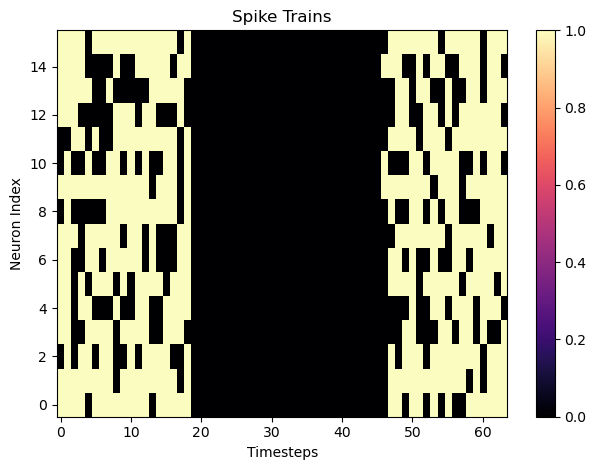

mel spikes:
torch.Size([64, 16, 64])
unique values in generated spikes:
 tensor([0., 1.])


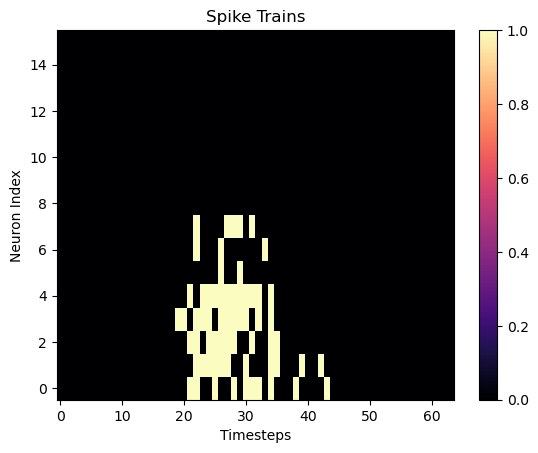

In [8]:
sample_inputs = sample_batch[0]
sample_spikes_rbf = encode_to_spikes_rbf(sample_inputs, 16000)
sample_spikes_mel = encode_to_spikes_melspec(sample_inputs, 16000)


# inspect spikes
print("rbf spikes:")
print(sample_spikes_rbf.shape)
# print(sample_spikes.unsqueeze(1).shape)
print("unique values in generated spikes:\n", sample_spikes_rbf.unique())

# sample spike train
plt.imshow(sample_spikes_rbf[0], aspect='auto', origin='lower', cmap='magma')
plt.title('Spike Trains')
plt.xlabel('Timesteps')
plt.ylabel('Neuron Index')
plt.colorbar()

plt.tight_layout()
plt.show()

print("mel spikes:")
print(sample_spikes_mel.shape)
# print(sample_spikes.unsqueeze(1).shape)
print("unique values in generated spikes:\n", sample_spikes_mel.unique())

# sample spike train
plt.imshow(sample_spikes_mel[0], aspect='auto', origin='lower', cmap='magma')
plt.title('Spike Trains')
plt.xlabel('Timesteps')
plt.ylabel('Neuron Index')
plt.colorbar()


In [ ]:
# old versio with bug fixed and dimensions set to 16 to fit with tuning curves
from models import customSNet_0
import snntorch as snn
from snntorch import functional as SF
from tqdm.notebook import tqdm


num_classes = 35
num_steps = 20
model = customSNet_0(num_steps = num_steps, beta = 0.9, threshold=1.0, spike_grad=snn.surrogate.fast_sigmoid(slope=25), num_class=num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()
sr = 16000  # Number of time steps to simulate
batch_size = 64
train_loss_hist = []
train_accu_hist = []
train_accu_hist_temp = []

n_epochs = 10

iterCount = 0
for epoch in tqdm(range(n_epochs), desc='Epoch', total=n_epochs, leave=True):
    for inputs, labels in tqdm(train_loader, desc='Iteration', total=len(train_loader), leave=False):
        optimizer.zero_grad()
        spikes = encode_to_spikes_rbf(inputs, sr)
        spike_input = spikes.unsqueeze(1)

        model.train()
        spk_rec, mem_rec = model(spike_input)
        labels = labels.long()
        loss_val = torch.zeros((1), dtype=torch.float)
        for step in tqdm(range(num_steps), desc='Time step', total=num_steps, leave=False):
            loss_val += loss_fn(mem_rec[step], labels)

        # Gradient calculation + weight update
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        avg_loss = loss_val.item()/len(train_loader)
        train_loss_hist.append(loss_val.item())
        acc = SF.accuracy_rate(spk_rec, labels)
        acc2 = SF.accuracy_temporal(spk_rec, labels)
        train_accu_hist.append(acc)
        train_accu_hist_temp.append(acc2)
        iterCount +=1
    print(f' Epoch: {epoch} | Train Loss: {train_loss_hist[-1]:.3f} | Avg Loss: {avg_loss:.3f} | Accuracy: {train_accu_hist[-1]:.3f} | Accuracy: {train_accu_hist_temp[-1]:.3f} | Iteration: {iterCount}')

In [40]:
# updated version with batch norm and decaying learning rate
from models import customSNet_1
import torch
import torch.nn as nn
import torch.optim as optim
import snntorch as snn
from torch.optim import lr_scheduler

# Hyperparameters
num_steps = 20
beta = 0.9
num_class = 35
learning_rate = 0.001
num_epochs = 10  # Adjust based on your needs

# Initialize model, loss, optimizer, and scheduler
model = customSNet_1(num_steps=num_steps, beta=beta, num_class=num_class)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)


# Example Training Loop with Validation
for epoch in tqdm(range(num_epochs), desc='Epoch', total=num_epochs, leave=True):
    model.train()
    running_loss = 0.0
    for data, labels in tqdm(train_loader, desc='Iteration', total=len(train_loader), leave=False):
        spikes = encode_to_spikes_rbf(data, sr)
        spike_input = spikes.unsqueeze(1)

        optimizer.zero_grad()
        output, _ = model(spike_input)
        # Aggregate outputs over time steps, e.g., mean
        output_mean = output.mean(dim=0)
        labels = labels.long()
        loss = loss_fn(output_mean, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * spike_input.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    
    # Validation phase
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for data, labels in test_loader:
            spikes = encode_to_spikes_rbf(data, sr)
            spike_input = spikes.unsqueeze(1)
            output, _ = model(spike_input)
            output_mean = output.mean(dim=0)
            preds = output_mean.argmax(dim=1)
            labels = labels.long()
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    
    val_accuracy = val_correct / val_total
    
    # Step the scheduler
    scheduler.step()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Learning Rate: {scheduler.optimizer.param_groups[0]['lr']:.6f}")

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/798 [00:00<?, ?it/s]

/tmp/ipykernel_731749/537872403.py:39: RuntimeWarning: invalid value encountered in divide
  y = (y - np.min(y, axis=0)) / (np.max(y, axis=0) - np.min(y, axis=0))


ValueError: lam value too large